# Generalised Least Squares
We will start our journey into the world of mixed-effects models by first examining a *related* approach that we have seen before: Generalised Least Squares (GLS). The reason for doing this is twofold. Firstly, GLS actually provides a simpler solution to many of the issues with the repeated measures ANOVA and thus presents a more logical starting point. Secondly, limitations in the way that GLS does this will provide some motivation for mixed-effects as a more complex, but ultimately more flexible, method of dealing with this problem.

## GLS Theory
We previously came across GLS in the context of allowing different variances for different groups of data in ANOVA-type models. This was motivated as a way of lifting the assumption of *homogeneity of variance*. However, GLS is actually a much more general technique. To see this, note that the probability model for GLS is

$$
\mathbf{y} \sim \mathcal{N}\left(\boldsymbol{\mu},\boldsymbol{\Sigma}\right),
$$

where $\boldsymbol{\Sigma}$ can take on *any structure*. In other words, GLS has exactly the same probability model as the normal linear model, except that it allows for a flexible specification of the variance-covariance matrix. In our previous examples, we used GLS to populate the variance-covariance matrix with different variances for each group. For instance, if we had two groups with three subjects each, our GLS model would be

$$
\begin{bmatrix}
y_{11} \\
y_{21} \\
y_{31} \\
y_{12} \\
y_{22} \\
y_{32} \\
\end{bmatrix}
\sim\mathcal{N}\left(
\begin{bmatrix}
\mu_{1} \\
\mu_{1} \\
\mu_{1} \\
\mu_{2} \\
\mu_{2} \\
\mu_{2} \\
\end{bmatrix},
\begin{bmatrix}
\sigma^{2}_{1}  & 0              & 0              & 0              & 0              & 0              \\
0               & \sigma^{2}_{1} & 0              & 0              & 0              & 0              \\
0               & 0              & \sigma^{2}_{1} & 0              & 0              & 0              \\
0               & 0              & 0              & \sigma^{2}_{2} & 0              & 0              \\
0               & 0              & 0              & 0              & \sigma^{2}_{2} & 0              \\
0               & 0              & 0              & 0              & 0              & \sigma^{2}_{2} \\
\end{bmatrix}
\right).
$$

This was actually a special case of GLS known as *weighted least squares* (WLS)[^weights-foot], where all the off-diagonal elements of $\boldsymbol{\Sigma}$ are 0. However, the crucial point is that  we can use GLS to impose differences in *both* the variances *and* the covariances. So while we did not do this previously, we can include *correlation* in the GLS model. Thus, if our general problem with repeated measures is that the variance-covariance structure is not correctly handled by the normal linear model, GLS provides a direct solution. Furthermore, if a core complaint of the repeated measures ANOVA is that the covariance structure that is assumed is too restrictive, GLS again provides a direct solution. So, on the face of it, GLS directly solves many of the issues we encountered last week.

### How Does GLS Work?
At its most basic, GLS uses the residuals of an initial model fit to estimate the covariance structure. This is then *removed* from the data. The corrected data is then, in theory, *uncorrelated* with *equal variance* and we can use OLS to estimate the parameters. This can all be achieved within a single estimation framework by using *restricted maximum likelihood* (REML). This will iteratively estimate the variance structure from the residuals and then estimate the parameters after removing the estimated variance structure. This continues until convergence (i.e. you get the same result on each subsequent iteration). So, the easiest way to understand GLS is as a method for *correcting* the data to make it suitable for a normal regression model. 

This perspective of GLS as a *correction technique* is important because to use GLS we have to 
    
1. Assume we know the covariance structure
2. Estimate this structure from the data
3. Remove the estimated structure and assume that OLS will then work fine

The focus here is very much on modelling the *covariance structure* as a correction technique. As we will see later, mixed-effects models work by modelling the *data structure* and allowing the associated covariance structure to fall-out naturally. This is a change in focus, but also arguably a more beneficial approach because the structure of the data is undeniable, yet the structure of the covariance is an *assumption*. Nevertheless, we have seen that the covariance structure itself *is* the problem for modelling repeated measurements and so we shall continue with this focus for now.


### Covariance Constraints
Perhaps one of the most important elements to recognise is that some sort of *constraint* is always needed when estimating a variance-covariance matrix. For a repeated measures experiment there are $nt \times nt$ values in this matrix. The values above and below the diagonal are a mirror image, so the true number of unknown values is $\frac{nt(nt + 1)}{2}$. For instance, if we had $n = 5$ subjects and $t = 3$ repeated measures, there would be $\frac{15 \times 16}{2} = 120$ unique values in the variance-covariance matrix. If we allowed it to be completely unstructured, we would have 120 values to estimate *just* for the covariance structure. Indeed, this is not really possible unless the amount of data we have *exceeds* the number of parameters. So, the data itself imposes a *constraint* on how unstructured the covariance matrix can be.

Luckily, for most applications, we not only assume that $\boldsymbol{\Sigma}$ has a block-diagonal structure (so most off-diagonal entries are assumed 0), but that many of the off-diagonal elements are actually *identical*. We saw this previously with the repeated measures ANOVA. Even though $\boldsymbol{\Sigma}$ may have *hundreds* of values we *could* fill-in, if we assume compound symmetry only within each subject, there are only *two* covariance parameters to be estimated: $\sigma^{2}_{b}$ and $\sigma^{2}_{w}$. The whole matrix can then be constructed using those two alone. This is an example of *extreme simplification*, but it does highlight that we generally do not estimate the *whole* variance-covariance matrix. We only estimate *small parts* of it. Indeed, making the covariance matrix more general is often a risky move because of the number of additional parameters needed. The more we estimate from the same data, the greater our uncertainty becomes. The standard errors will get *larger* because they are supported by *less data*, which will ultimately harm our inference. Complexity always comes with a price, especially working with something like the variance-covariance matrix.

## GLS in `R`
We have seen some examples of using the `gls()` function from `nlme` last semester. At that point, we only focused on the use of the `weights=` argument with different variance structures (e.g. `varIdent()`, `varPower()` etc.). However, there is also a `correlation=` argument that similarly takes a number of pre-specified correlation structures. We can use these two arguments together to form a final variance-covariance matrix that consists of correlation and heterogenous variance groups. 

### The Paired $t$-test Using GLS
We can start with the most simple example of the paired $t$-test using GLS. Importantly, this is an unnecessary step theoretically because the paired $t$-test is a perfectly acceptable technique. When there are only two-repeats there are no arguments about the covariance structure. There can only be a single correlation term. So compound symmetry always works. However, it is useful for us as a *starting point* because it is the simplest example of the problem.

In order to specify a correlation structure, we need to pass one of the predefined correlation functions as an argument to `correlation=`. These structures include functions such as `corCompSymm()`, `corSpher()`, `corAR1()` and `corSymm()`[^corfunc-foot]. For this example, we will use `corCompSymm()`, which constructs a compound symmetric structure.

In order to use `corCompSymm()`, we need to supply it with a description of how we want it structured in relation to our data. This is done using the `form=` argument, which takes a one-sided formula expressing the structure we want. For this example, we will use `corCompSymm(form= ~1|subject)`. This indicates that we want a constant correlation (`1`) grouped by subject (`|subject`). So, the term on the *right* of `|` is key here. This gives a *grouping factor* such that any observations from the same level will share a constant correlation. Because we have used `subject`, each level represents a *different* subject and thus any observations that come from the same subject will be correlated. This therefore defines our *block-diagonal* covariance structure, where the term on the right of `|` forms the *blocks*. We will see ways to visualise this in order to provide more intuition a little later.

Returning to our example, we will use the `mice2` data from `datarium` again, which we have converted to long-format as discussed last week.

In [1]:
library('datarium')
library('reshape2')
data('mice2')

# repeats and number of subjects
t <- 2
n <- dim(mice2)[1]

# reshape wide -> long
mice2.long <- melt(mice2,                       # wide data frame
                   id.vars='id',                # what stays fixed?
                   variable.name="time",        # name for the new predictor
                   value.name="weight")         # name for the new outcome

mice2.long <- mice2.long[order(mice2.long$id),] # order by ID
rownames(mice2.long) <- seq(1,n*t)              # fix row names
mice2.long$id <- as.factor(mice2.long$id)

print(mice2.long)

   id   time weight
1   1 before  187.2
2   1  after  429.5
3   2 before  194.2
4   2  after  404.4
5   3 before  231.7
6   3  after  405.6
7   4 before  200.5
8   4  after  397.2
9   5 before  201.7
10  5  after  377.9
11  6 before  235.0
12  6  after  445.8
13  7 before  208.7
14  7  after  408.4
15  8 before  172.4
16  8  after  337.0
17  9 before  184.6
18  9  after  414.3
19 10 before  189.6
20 10  after  380.3


To fit this model using GLS, we use

In [2]:
library(nlme)

gls.mod <- gls(weight ~ time, correlation=corCompSymm(form=~1|id), data=mice2.long)

where we can see the use of the `correlation=` argument with the `corCompSymm()` function. We could also optionally include a `weights=` argument if we wanted the diagonal elements of the covariance matrix to differ by `time`. This would take the form `weights=varIdent(form= ~1|time)`. However, we will keep this simple for now.

### Inference Using GLS
Although we should check the assumptions of the GLS model, we will leave that to one side given that we covered it last semester. The more pressing issue for us is to discuss *inference* using the GLS model. To begin with, we can treat the returned objects from `gls()` just like an object from `lm()` and call `summary()` to examine the model estimates and tests.

In [3]:
print(summary(gls.mod))

Generalized least squares fit by REML
  Model: weight ~ time 
  Data: mice2.long 
      AIC      BIC    logLik
  177.349 180.9105 -84.67449

Correlation Structure: Compound symmetry
 Formula: ~1 | id 
 Parameter estimate(s):
      Rho 
0.5332493 

Coefficients:
             Value Std.Error  t-value p-value
(Intercept) 200.56  8.081914 24.81591       0
timeafter   199.48  7.808574 25.54628       0

 Correlation: 
          (Intr)
timeafter -0.483

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.46661859 -0.54818094  0.02112903  0.38482224  1.79048964 

Residual standard error: 25.55725 
Degrees of freedom: 20 total; 18 residual


We can see here all the usual output that matches what `lm()` gives us. We also have information on the estimated correlation structure, with the single correlation parameter given by $\hat{\rho} = 0.53$. Of most importance is that both the *standard error* and *$t$-value* match what we saw last week from the paired $t$-test. This is evidence enough to show that the correlation *is* being taken into account. Importantly, this is being done within a linear model framework, but *without* the need to subtract the differences *or* to manually partition the errors by including `id` in the model formula. We can also compare this with the output from the paired $t$-test

In [10]:
print(t.test(mice2$before, mice2$after, paired=TRUE))


	Paired t-test

data:  mice2$before and mice2$after
t = -25.546, df = 9, p-value = 1.039e-09
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 -217.1442 -181.8158
sample estimates:
mean difference 
        -199.48 



#### The $p$-value Problem
Although all the elements highlighted above are positives, there is a problem here in terms of the calculation of the $p$-value. The issue is that the covariance structure has been *estimated* and this creates additional uncertainty. In the normal linear model, we use the null $t$-distribution for the parameters because the $t$-statistics is formed as the ratio of *two* estimates. This takes into account the uncertainty in the parameter estimate *and* the uncertainty in the standard error[^student-foot]. This only works because the distribution of the parameter estimate is known *and* the distribution of the standard error is known. Unfortunately, when we get into complex covariance matrices built from *multiple* parameters, the distribution of the standard error is *no longer known*. This means we have no idea what the null distribution of the test statistic is anymore. We need the null distribution in order to compute a $p$-value, so when this is unknown what can we do?

#### A Tale of Two Worlds
In order to understand the solution used by `gls()`, it is useful to think about two hypothetical worlds: one where $\boldsymbol{\Sigma}$ is already known and one where $\boldsymbol{\Sigma}$ is *unknown* and must be estimated from the data. Of course, we know we live in the second world, but let us see the consequences on the inferential procedures of both these possibilities

- World 1: $\boldsymbol{\Sigma}$ is known
    - The covariance structure can be removed *exactly* from the data. 
    - This removal renders the errors truly $i.i.d.$ and transforms the model back into a normal regression model
    - ... Degrees of freedom exist as an easily countable quantity ...

- World 2: $\boldsymbol{\Sigma}$ is *unknown*
    - $\hat{\boldsymbol{\Sigma}}$ is now a random matrix that will change for each sample
    - Because of this, ...
    - ... Degrees of freedom completely disappear as a easily countable quantity that expresses independent information.

So, as we can see, World 2 is messy and difficult and does not allow for easy calculation of a $p$-value. So what does `gls()` do? It pretends that we are in World 1 instead.

Where some of this falls apart is in the disagreement between `gls()` and the repeated measures ANOVA in terms of the degrees of freedom. As indicated above, degrees of freedom only exist if we pretend that $\boldsymbol{\Sigma}$ is known. However, by doing that, `gls()` makes no concession to the uncertainty introduced by estimating $\boldsymbol{\Sigma}$, because of course we are pretending that we have *not* estimated it. As such, the repeated measures structure of the data that is embedded in $\boldsymbol{\Sigma}$ is *ignored*. Under the repeated measures ANOVA, the uncertainty induced by estimating this structure is implicit in the fact that each subject causes a loss in the degrees of freedom.

...

The only way we can get around this problem is to assume that our estimate of $\boldsymbol{\Sigma}$ *is* the true population covariance matrix. Now, of course, this is *not* true. However, if it *were* true then the covariance structure could be fully removed from the data and we would be back in the world of ordinary least squares. At that point, we have paid *no penalty* for estimation (because $\boldsymbol{\Sigma}$ is a known constant) and we can treat our model in exactly the same way as before. This makes everything nice and easy and we can just treat the GLS results exactly the same as any other regression model. This is exactly what `gls()` does. So, the $t$-statistics and $p$-values reported in the results table from `gls()` are based on assuming $\boldsymbol{\Sigma}$ is known and that we can just use the same inferential machinery as a regular regression model. However, the accuracy of doing this is highly questionable.

Beyond the somewhat fanciful nature of this solution, the other issue is that the GLS model does not account for the uncertainty created by estimating the covariance structure. If you pretend that we *know* $\boldsymbol{\Sigma}$ exactly, then there is no penalty (because no estimation has taken place). However, in reality, we *have* estimated $\boldsymbol{\Sigma}$ and this *should* be accommodated. We can see this in the difference between the degrees of freedom in the GLS model and the paired $t$-test results.  ... In the repeated measures ANOVA, the uncertainty in estimating the covariance structure is implicit in the fact that the subjects appear in the model and we lose degrees of freedom accordingly. In GLS, we *should* be losing degrees of freedom for estimating $\boldsymbol{\Sigma}$, but this is being ignored. The structure of the data is terms of repeated measures is *hidden* in the structure of $\boldsymbol{\Sigma}$. But because the uncertainty around estimating this is being *ignored*, so too is that structure being ignored. In fact,

#### Omnibus Tests and Follow-ups
... Notice that the `Anova()` function does not return $F$-statistics, it instead returns *asymptotic* $\chi^{2}$-statistics. This is important because `Anova()` refuses to play the "pretend degrees of freedom" game that `gls()` does. Instead, `Anova()` accepts that the concept of residual degrees of freedom no longer exist and does not try to get them back again. Instead, we construct a test statistic where its behaviour is known when $\boldsymbol{\Sigma}$ is exact. Of course, $\boldsymbol{\Sigma}$ is *not* exact, it is still an estimate. However, if we assume the sample size is large enough then any uncertainty in $\boldsymbol{\Sigma}$ becomes negligible, we can treat $\hat{\boldsymbol{\Sigma}} = \boldsymbol{\Sigma}$ and we know exactly how the statistic will behave under the null. So this is an *asymptotic* statistic that becomes more accurate the larger the sample size. As the sample gets bigger, $\hat{\boldsymbol{\Sigma}}$ gets closer and closer to the true $\boldsymbol{\Sigma}$ and the null distribution becomes known. This approach has a certain *statistical purity* to it because we can ignore all the complication with degrees of freedom and null distributions. The price is that we have to use this very carefully in small samples, *especially* when the $p$-values are very marginal.

Follow-up tests can also be performed here using `emmeans` and the same syntax we saw last semester. For instance

So we can see that GLS already provides a nice alternative to the repeated measures ANOVA because it exists within the linear model framework and thus allows us to use all the methods we have already learned previously.

## The GLS Covariance Matrix

In [4]:
getVarCov(gls.mod)

Marginal variance covariance matrix
       [,1]   [,2]
[1,] 653.17 348.30
[2,] 348.30 653.17
  Standard Deviations: 25.557 25.557 

In [5]:
library(Matrix)

gls_marginal_cov <- function(fit) {
  n <- nobs(fit)

  # Correlation blocks (list) or single matrix if no grouping
  cs <- fit$modelStruct$corStruct
  if (is.null(cs)) {
    # No correlation structure: R = I
    Rlist <- list(Matrix::Diagonal(n))
    g <- factor(rep("all", n))
  } else {
    Rlist <- corMatrix(cs)
    g <- getGroups(fit)
    if (is.null(g)) g <- factor(rep("all", n))
  }

  # Variance weights (if no varStruct, all 1s)
  vs <- fit$modelStruct$varStruct
  w <- if (is.null(vs)) rep(1, n) else varWeights(vs)

  # Indices per group, aligned to the same order as used in the fit
  idx <- split(seq_along(g), g)

  sig2 <- fit$sigma^2

  # Build block covariance matrices: Sigma_g = sig2 * D^(1/2) R D^(1/2)
  # In nlme, varWeights are (typically) inverse-SD-type weights, so Var(e_i) = sig2 / w_i^2.
  Sig_blocks <- Map(function(R, ii) {
    Dhalf <- Matrix::Diagonal(x = 1 / w[ii])
    sig2 * (Dhalf %*% R %*% Dhalf)
  }, Rlist, idx)

  Matrix::bdiag(Sig_blocks)
}

We just print the first 8 rows to show the structure for the first 4 subjects.

In [6]:
Sigma <- gls_marginal_cov(gls.mod)
print(Sigma[1:8,1:8])

8 x 8 sparse Matrix of class "dgCMatrix"
                                                                            
[1,] 653.1733 348.3042   .        .        .        .        .        .     
[2,] 348.3042 653.1733   .        .        .        .        .        .     
[3,]   .        .      653.1733 348.3042   .        .        .        .     
[4,]   .        .      348.3042 653.1733   .        .        .        .     
[5,]   .        .        .        .      653.1733 348.3042   .        .     
[6,]   .        .        .        .      348.3042 653.1733   .        .     
[7,]   .        .        .        .        .        .      653.1733 348.3042
[8,]   .        .        .        .        .        .      348.3042 653.1733


A more general approach is to create an *image* of $\boldsymbol{\Sigma}$, either as a whole

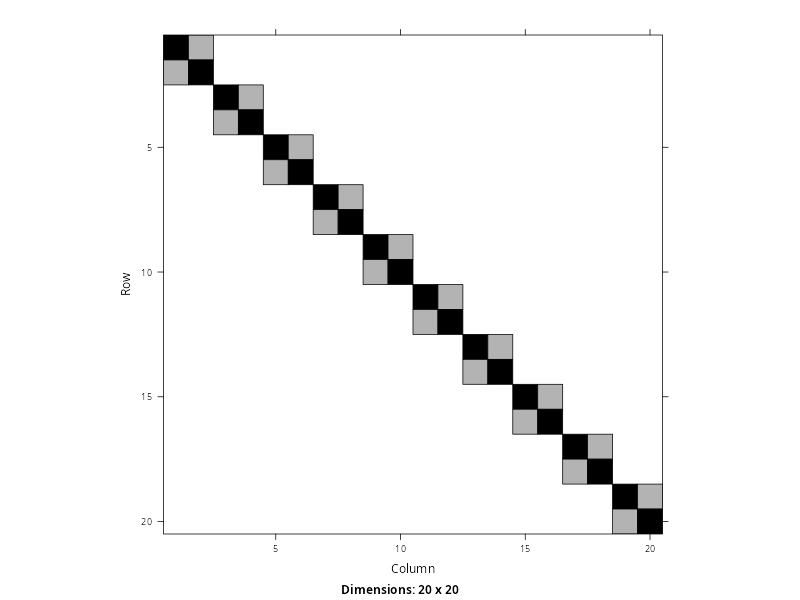

In [7]:
image(Sigma)

Or subsetted to show the general structure more clearly

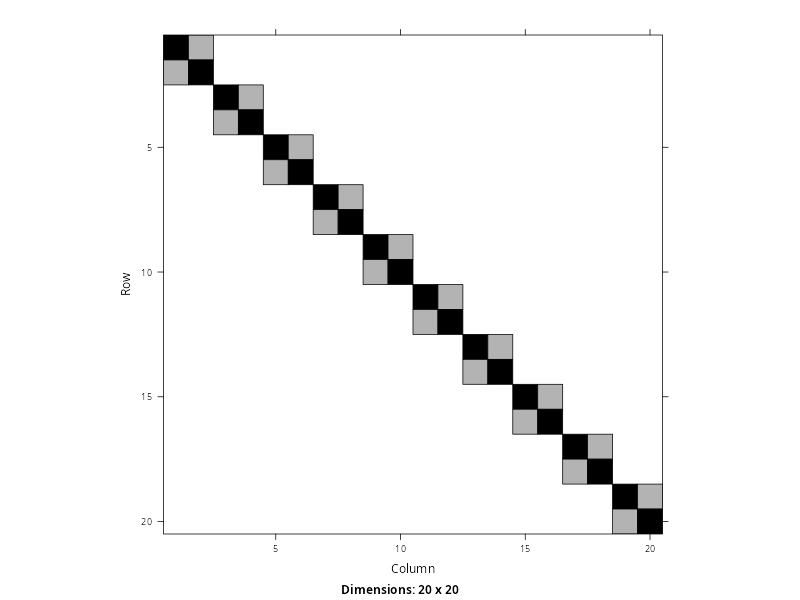

In [8]:
image(Sigma[1:20,1:20]) # first 10 subjects

These visualisations also help to make sense of the syntax used for defining the correlation structure. For instance, if we were to specify `form=~1|cond`, this would imply a constant correlation for each level of the repeated measures condition. What would this look like? Let us see

In [9]:
gls.mod <- gls(y.long ~ cond, correlation=corCompSymm(form=~1|cond))
image(gls_marginal_cov((gls.mod)))

: [1m[33mError[39m:[22m
[33m![39m object 'cond' not found

The data are now organised by whatever term is on the *right* of `|`, so the first 50 rows represent all the data from condition 1 and the final 50 rows represents all the data from condition 2. So we can see that this structure implies that all the data from condition 1 are correlated across subjects, and all the data from condition 2 are correlated across subjects. This is not particularly sensible or meaningful, but hopefully it makes it clear how the syntax works.

Notice, however, that GLS is ignoring the structure in the data in terms of the subjects, because it has no knowledge of them.

## GLS for ANOVA Models
In the above example, we saw the use of GLS as an alternative to the paired $t$-test. A more usual application would be as an alternative to the Repeated Measures ANOVA as a means of side-stepping all the messy specification of different error terms for different tests.

### ANOVA Models with More Flexible Variance Structures
Perhaps the most useful elements of GLS is that we can use much more flexible variance structures than the simple compound-symmetric structure assumed by RM ANOVA. For instance, we can ask for a completely free within-subject correlations and a different variance for each between-subject group. For instance, specifying `corSymm(form=~1|subject)` and `varIdent(form=~1|group)` gives the most flexible structure that allows all correlations and variances to differ. However, we have to be careful because it is possible that there simply is not enough information in our data to allow this to be estimated, even if we want it.

## Why Not Stop at GLS?
... The problem is that GLS does not know anything about the *structure* of the data. It has no sense of *subjects* as the experimental unit, nor the idea that the outcome variable is comprised of clusters of values taken from different subjects who might themselves form clusters of values from larger groups (e.g. patients vs controls). All that GLS knows is that there is a correlation structure that we want to remove. Unfortunately, this lack of appreciation for the structure of the data means that GLS cannot use that structure to its advantage. There is no separation of the information available by pooling observations across subjects, or subjects across groups. In effect, GLS is a very *crude* solution to a bigger problem with repeated measurements. Namely, that there is a larger *hierarchical* structure at play that the model should be able to take advantage of. We have seen this in a very general way through small-sample degrees of freedom, but really this is only a *symptom* of a larger problem. As we will come to learn, mixed-effects models are advantageous precisely *because* they embed this structure in the model. This has a number of consequences, not least the fact that correlation between measurements from the same experimental unit are *automatically* embedded in the model. This is not because we tell the model to include correlation, rather it is a *natural consequence* of the structure of the data. As such, mixed-effects models are useful because features such as correlation are a natural part of the modelling framework, precisely because it does take the structure into account in a way that GLS simply cannot.

## When Can We Use GLS?
In reality, a GLS model is useful if you do not care about the hypothesis tests and just want estimates that accommodate a given correlation structure, or if you are using non-repeated measurement data and want a more flexible between-subjects variance structure. Alternatively, if you are taking many measurements from a *single* subject, GLS can be useful to model just their individual data. For instance, time-series data from one subject as measured using EEG, or eye-tracking, or continuous monitoring of hand movement. In these cases you can end up with thousands of data points and GLS can be used to model it using some suitable correlation structure (e.g. `corAR1(form=~time)`). The estimates could then be used as summary statistics to analyse multiple subjects[^summarystat-foot]. However, as we have seen above, GLS is not necessarily suitable for multiple subjects with repeated measurements because it does not accommodate the blocked structure of the data and thus fails to consider how this changes the number of independant pieces of information. This can be side-stepped by using asymptotic statistics that do not depend upon the concept of degrees of freedom. In large samples, this issue disappears, so if you have a large sample, or are willing to treat the $p$-values cautiously in small samples, GLS is a perfectly legitimate solution to the problem.

[^summarystat-foot]: This approach is, unsurprisingly, known as a *summary statistics* approach and is typical of how data analysis is handled for fMRI and M/EEG data.

[^weights-foot]: This is why the argument in `gls()` was `weights=`.

[^corfunc-foot]: You can look up descriptions of all of these using `?corClasses` at the prompt. 

[^student-foot]: Remember that historically the uncertainty in the standard error was *not* taken into account. Statisticians assumed that they could treat the standard error as a *known constant*, at which point the null distribution is simply a scaled version of the distribution of the numerator. For the normal linear model, this would mean using a *standard normal* distribution (or $z$-distribution) for inference. It was Student's insight that this does not always hold because the uncertainty in the standard error *changes* the distribution, with this change becoming more extreme the smaller the sample. 